<a href="https://colab.research.google.com/github/ulewis/FdD/blob/main/Balanceo%20ROS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [658]:
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [659]:
# Extraemos datos
data='para volumen 4ta vuelta.csv'

In [660]:
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

,C,Rp,Dif_vol,V_in,V_out,P_ventilador,PIP,Error_aceptable
0,20,20,-2.7,350,352.7,27.6,25.5,1
1,20,20,-4.7,350,354.7,30.3,30.2,1
2,20,20,1.2,350,348.8,32.0,33.0,1
3,20,20,3.1,400,396.9,30.3,29.4,1
4,20,20,-7.0,400,407.0,33.9,34.3,1


In [661]:
#Revisamos dimension de la data
df.shape

(69, 8)

In [662]:
#filtramos decartando columnas con datos faltantes
d_filtrado = df.dropna().copy() 

In [663]:
#Verificamos cuantos valores tenemos de Rp
d_filtrado.P_ventilador.unique()

array([27.6, 30.3, 32. , 33.9, 35.2, 38.8, 36.4, 37.7, 35.5, 38.9, 40.5,
       41.1, 43.5, 54.1, 44.5, 47. , 49.1, 33.4, 36.3, 38.4, 38.2, 41.6,
       43.3, 41.2, 45.5, 47.8, 43.6, 48.3, 51.2, 51.1, 55. , 57.8, 56.2,
       59.8, 33.2, 37.4, 39.5, 37.6, 42.8, 45. , 48. , 51.6, 52.2, 55.5,
       59. , 61.3, 64.5, 66.8, 69. , 26.9, 32.3, 29.5, 37. , 32.6, 38. ,
       40.9, 36.8, 44. , 47.4, 45.9, 54.6, 53.7, 58.4])

In [664]:
#revisamos de la data filtrada
d_filtrado.shape

(69, 8)

In [665]:
#contar valores
d_filtrado['Error_aceptable'].value_counts()

1    53
0    16
Name: Error_aceptable, dtype: int64

In [666]:
#revisamos proporción
d_filtrado['Error_aceptable'].value_counts()/len(d_filtrado)

1    0.768116
0    0.231884
Name: Error_aceptable, dtype: float64

In [667]:
#observamos el desbalance de datos
p=sns.catplot(data = d_filtrado, kind ='count', x= 'Error_aceptable')
p.set(title = "clases")

### Variables que se mediran
---

In [668]:
Variables = ['V_in','P_ventilador']

--- 

In [669]:
# definimos la matriz de caracteristicas
x = d_filtrado.loc[:,Variables]
y = d_filtrado['Error_aceptable']

In [670]:
print(len(y[y==0]))
print(len(y[y==1]))

16
53


In [671]:
#divimos la data en conjunto de entranimiento y test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0)
print(len(x_train),len(x_test))

51 18


In [672]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))

11
40


In [673]:
# Estandarización de características
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [674]:
print(df.head())

    C  Rp  Dif_vol  V_in  V_out  P_ventilador   PIP  Error_aceptable
0  20  20     -2.7   350  352.7          27.6  25.5                1
1  20  20     -4.7   350  354.7          30.3  30.2                1
2  20  20      1.2   350  348.8          32.0  33.0                1
3  20  20      3.1   400  396.9          30.3  29.4                1
4  20  20     -7.0   400  407.0          33.9  34.3                1


REGRESIÓN LOGISTICA

In [675]:
from sklearn.linear_model import LogisticRegression
regLog = LogisticRegression(random_state = 0)
regLog.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [676]:
# Se añade una columna constante para el término de intercepción
x_train_with_const = sm.add_constant(x_train)

# Crear un modelo logístico con statsmodels
logit_model = sm.Logit(y_train, x_train_with_const)

# Ajustar el modelo
result = logit_model.fit()

# Obtener los coeficientes y los p-valores
coefficients = result.params
p_values = result.pvalues

print("Coeficientes:")
print(coefficients)
print("\nP-valores:")
print(p_values)

Optimization terminated successfully.
         Current function value: 0.465769
         Iterations 6
Coeficientes:
const    1.517487
x1       0.913310
x2       0.000904
dtype: float64

P-valores:
const    0.000239
x1       0.154247
x2       0.998909
dtype: float64


In [677]:
score = regLog.score(x_test, y_test)
round(score,4)

0.7222

In [678]:
y_pred = regLog.predict(x_test)

In [679]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.86      0.50      0.42        18
weighted avg       0.80      0.72      0.61        18



In [680]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  5]
 [ 0 13]]


In [681]:
pd.crosstab(y_test,y_pred)

col_0,1
Error_aceptable,
0,5
1,13


In [682]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regLog, X = x_train, y=y_train, cv= 10)
accuracies.mean()

0.7866666666666667

In [683]:
accuracies

array([0.66666667, 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


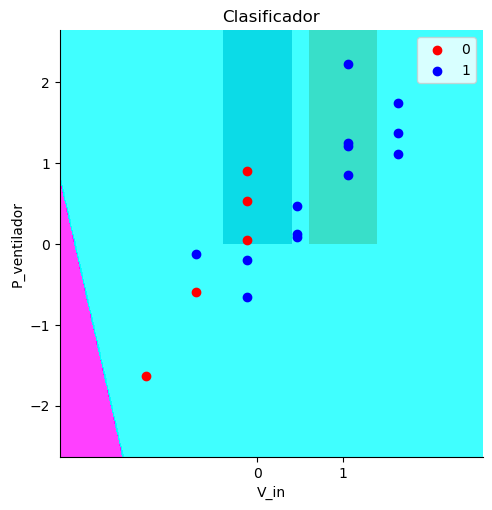

In [684]:
# Creamos un plot para ver la frontera de clasificación

from matplotlib.colors import ListedColormap
x_set, y_set = x_test, y_test
X1,X2 = np.meshgrid(np.arange(start = x_set[:,0].min()-1,stop = x_set[:,0].max()+1,step=0.01),
                    np.arange(start = x_set[:,1].min()-1,stop = x_set[:,0].max()+1,step=0.01))
plt.contourf(X1,X2, regLog.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap = ListedColormap(('magenta', 'cyan')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i,j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],
                c = ListedColormap(('red','blue'))(i),label = j)
    
plt.title('Clasificador')
plt.xlabel(Variables[0])            #<-----Variables
plt.ylabel(Variables[1])            #<-----Variables
plt.legend()
plt.show()



**Balanceo ROS**

In [685]:
len(x_train)

51

In [686]:
train = np.concatenate([x_train, y_train.values.reshape(-1,1)], axis=1)

In [687]:
#transformamos a un dataFrame
train = pd.DataFrame(train,columns=[Variables[0],Variables[1],'Error_aceptable'])

In [688]:
#obtenemos la clase con error que no se acepta
train_class_0 = train.query("Error_aceptable == 0")
train_class_0.head()

,V_in,P_ventilador,Error_aceptable
10,-0.716967,0.223825,0.0
12,0.462559,0.960943,0.0
13,-0.716967,-0.779474,0.0
16,-0.716967,-1.363025,0.0
20,-1.306730,-0.984229,0.0


In [689]:
train_class_0.shape

(11, 3)

In [690]:
n_class0 = len(train.query("Error_aceptable == 0"))
n_class1 = len(train.query("Error_aceptable == 1"))
print ( n_class0, n_class1)

11 40


In [691]:
i_class0_downsampled = train_class_0.sample(n_class1,replace = True)
len(i_class0_downsampled)

40

In [692]:
new_train = pd.concat([train.query("Error_aceptable == 1"), i_class0_downsampled], axis=0)
new_train[['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

In [693]:
new_x_train =new_train.loc[:,Variables].values
new_y_train =new_train.loc[:,['Error_aceptable']].values


In [694]:
new_y_train = pd.Series(new_y_train.reshape(-1,))

In [695]:
new_train.loc[:,['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

Nuevo modelo con nueva data

In [696]:
model= LogisticRegression()
model. fit(new_x_train, new_y_train)

LogisticRegression()

In [697]:
y_pred2 = model.predict(x_test)

In [698]:
print(classification_report(y_test, y_pred,zero_division=1))
print(classification_report(y_test, y_pred2,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.86      0.50      0.42        18
weighted avg       0.80      0.72      0.61        18

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.80      0.92      0.86        13

    accuracy                           0.78        18
   macro avg       0.73      0.66      0.68        18
weighted avg       0.76      0.78      0.76        18

